## 5. Model

Model bude trieda plniaca nasledovne ucely:
- Bude obsahovat zoznam vrstiev
- Bude implementovat algoritmus trenovania
- Bude vediet spocitat predikciu

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from backstage.utils import dataset_Circles, draw_DecisionBoundary, MakeBatches
from backstage.layer import Input, Dense
from backstage.loss import CreateLossFunction
from backstage.optimizer import GradientDescent


### 1. Inicializacia

Z konstruktoru dostaneme zoznam vrstiev. A do metody initialize dostaneme aj stratovu funkciu a optimizer, ktore budeme pouzivat pri uceni. Postupne zavolame inicializaciu na vsetkych vrstvach, aby si mohli nainicializovat svoje vnutorne parametre - vahy, bias.

In [3]:
class Model:
    def __init__(self, layers):
        self.layers = layers
        self.loss = None
        self.optimizer = None

    def initialize(self, loss, optimizer):
        # Nase vlastne si odlozime
        self.loss = loss
        self.optimizer = optimizer

        # 1. Inicializujeme vsetky vrstvy
        prevLayer = None
        for l in self.layers:
            l.initialize(prevLayer)
            prevLayer = l  


### 2. Priamy prechod

Implementujeme metodu __forward__, ktora postupne zavola priamy vypocet na vsetkych vrstvach - vypoctovy graf.
Implementujeme aj metodu __call__, ktoru zase budeme pouzivat pri kresleni decision boundary. Jeden rozdiel medzi __forward__ je, ze __forward__ vracia yhat - pravdepodobnosti, ze vzorky prisluchaju niektorej triede. Predikcia cez __call__ uz urobi rozhodnutie a vrati priamo triedu - 0 alebo 1.

In [4]:
class Model(Model):
    
    def forward(self, x):
        # 2. Priamy prechod - predikcia
        a = x
        for l in self.layers:
            a, _ = l.forward(a)
        return a

    def __call__(self, x):
        # Len 2 triedy nas tu zaujimaju
        a = self.forward(x)
        a = (a > 0.5).astype(float)
        return a


### 3. Ucenie jednej davky

Implementujeme metodu __trainSingleStep__, ktora vykonava 3 kroky ucenia tak, ako sme si o nich hovorili v teoretickej casti.

In [5]:
class Model(Model):
    
    def _trainSingleStep(self, x, y):
        #
        #   Jeden krok ucenia:
        #           x = minibatch z trenovacej mnoziny
        #           y = minibatch label
        #
        #   Vraciame:
        #           loss = vektor strat pre davku (pozor! toto nie je cost!)
        #

        #   1. Priamy prechod - vypocitame hodnotu loss
        #   2. Spatny prechod - vypocitame hodnoty gradientov (vnutorne data vrstvy/optimizer kontextu)
        #   3. Uprava parametrov - zostup podla gradientu

        #   1. Priamy prechod
        a = x
        forwardCache = []
        for l in self.layers:
            aNext, layerCache = l.forward(a)
            # Odkladame si (Vrstvu, cache data z vrstvy - (W, b, z), a aktivaciu z predchadzajucej vrstvy)
            forwardCache.append((l, layerCache, a))
            a = aNext

        # Spocitame hodnotu straty - vektor pre kazdu vzorku z minibatchu
        # a spocitame derivaciu stratovej funkcie podla poslednej aktivacie.
        loss = self.loss(a, y)
        da = self.loss.derivative(a, y)

        #   2. Spatny prechod - v opacnom poradi od konca k zaciatku
        for l, layerCache, aPrev in reversed(forwardCache):
            daPrev = l.backward(da, aPrev, layerCache, self.optimizer)
            da = daPrev

        #   3. Update parametrov
        for l in self.layers:
            l.update(self.optimizer)

        return loss

### 4. Ucenie na celej trenovacej mnozine

A na koniec implementujeme metodu __train__, ktora opakovane prechadza celou trenovacou mnozinou - epochy.
Po dokonceni kazdej epochy vykonava validaciu pomocou validacnej "Dev Set" mnoziny.

Vysledkom je __Dictionary__ obsahujuci statistiky z ucenia. Tieto je mozne vizualizovat do grafu.


In [6]:
class Model(Model):
    
    def train(self, X, Y, epochs, batchSize, devX=None, devY=None):

        # 3. Ucenie - budeme vykonavat iteracie (epochy) cez nasu trenovaciu mnozinu.

        # Nasekame trenovaciu mnozinu
        _, m = X.shape
        data = MakeBatches((X, Y), batchSize)

        # Budeme vykonavat aj validaciu ?
        doValidation = True
        if (devX is None or devY is None):
            doValidation = False

        # Dictionary pre vysledky
        results = {
            "epochs": [],
            "loss": [],
            "val_loss": []
        }

        for epoch in range(epochs):

            # Akumulator pre training loss
            trainLossAcc = 0.0
            for batchX, batchY in data:
                loss = self._trainSingleStep(batchX, batchY)               
                trainLossAcc += np.sum(loss)

            # Odkladame si vysledok za tuto epochu
            results["epochs"].append(epoch)
            results["loss"].append((1.0 / m) * trainLossAcc)       # Toto je Cost J !

            # Validacia ?
            if (doValidation):
                yhat = self.forward(devX)
                _, devm = yhat.shape
                valLoss = self.loss(yhat, devY)
                results["val_loss"].append((1.0 / devm) * np.sum(valLoss))       # Aj toto je Cost J !
        
            # A este raz za 1000 epoch napiseme aktualny stav
            if (epoch % 1000 == 0):
                if (doValidation):
                    print('Epoch {0}:  Loss = {1:.7f}   Val_Loss = {2:.7f}'.format(
                        epoch, results["loss"][epoch], results["val_loss"][epoch])
                    )
                else:
                    print('Epoch {0}:  Loss = {1:.7f}'.format(epoch, results["loss"][epoch]))

        return results


### 5. Vizualizacia priebehu ucenia

Velmi velmi velmi odporucam vzdy vsetko kreslit do grafu. Textove vypisy nedokazu nahradit vypovednu hodnotu grafu. Obzvlast, ked budete neskor porovnavat spravanie sa desiatok alebo stoviek kombinacii hyperparametrov.


In [7]:
def draw_TrainingResults(results):

    # Inicializacia - logaritmicka mierka na Y osi
    plt.figure(figsize=(9, 9))
    plt.xlabel('Epoch')
    plt.xscale('linear')
    plt.yscale('log')

    # Dva grafy - training loss, validation loss
    plt.plot(results["epochs"], results["loss"], 'b', label='loss')
    plt.plot(results["epochs"], results["val_loss"], 'r', label='val_loss')
    
    plt.legend()
    plt.show()
    plt.close()


### 6. Go baby !

A teraz to mozeme rozbalit v plnej parade.

Epoch 0:  Loss = 0.7947479   Val_Loss = 0.7390758
Epoch 1000:  Loss = 0.5733538   Val_Loss = 0.6180895
Epoch 2000:  Loss = 0.5243141   Val_Loss = 0.5736967
Epoch 3000:  Loss = 0.4780392   Val_Loss = 0.5267185
Epoch 4000:  Loss = 0.4359290   Val_Loss = 0.4809442
Epoch 5000:  Loss = 0.3947164   Val_Loss = 0.4306649
Epoch 6000:  Loss = 0.3506184   Val_Loss = 0.3721280
Epoch 7000:  Loss = 0.3113274   Val_Loss = 0.3189210
Epoch 8000:  Loss = 0.2773472   Val_Loss = 0.2753928
Epoch 9000:  Loss = 0.2500991   Val_Loss = 0.2422333
Epoch 10000:  Loss = 0.2282783   Val_Loss = 0.2168425
Epoch 11000:  Loss = 0.2105894   Val_Loss = 0.1979850
Epoch 12000:  Loss = 0.1959537   Val_Loss = 0.1831054
Epoch 13000:  Loss = 0.1834604   Val_Loss = 0.1707380
Epoch 14000:  Loss = 0.1727090   Val_Loss = 0.1607515
Epoch 15000:  Loss = 0.1633293   Val_Loss = 0.1521751
Epoch 16000:  Loss = 0.1551338   Val_Loss = 0.1449203
Epoch 17000:  Loss = 0.1480086   Val_Loss = 0.1383971
Epoch 18000:  Loss = 0.1416565   Val_Loss

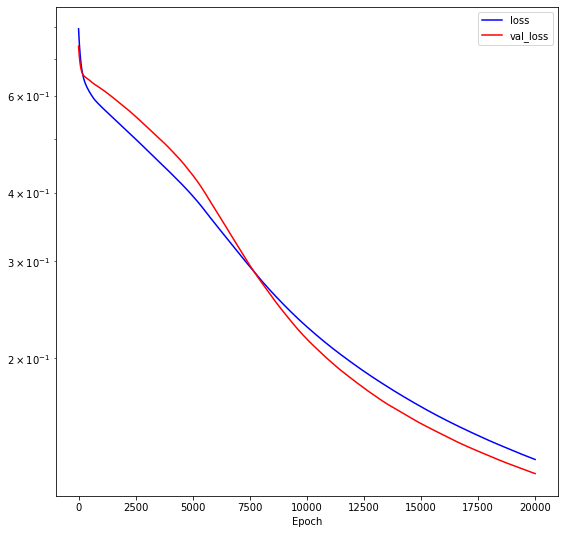

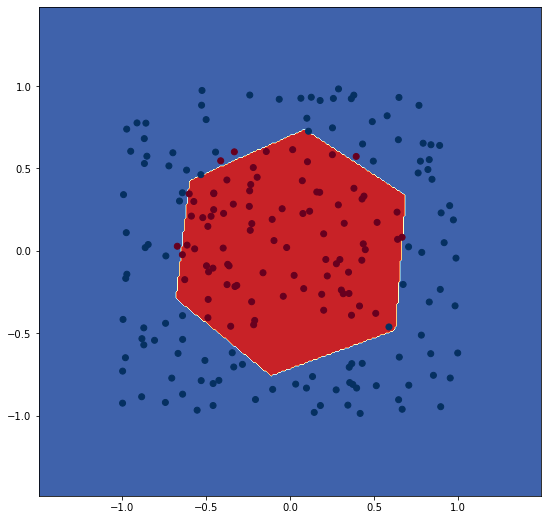

In [8]:
def test_Model():

    np.random.seed(10)

    # Spravime dataset
    X, Y = dataset_Circles(m=1000)
    devX, devY = dataset_Circles(m=200)

    nx, m = X.shape
    ny, _ = Y.shape

    # Skusime otestovat, ci nam to dobre funguje
    model = Model([
        Input(nx),
        Dense(5, act='relu'),
        Dense(ny, act='sigmoid')
    ])

    # Inicializujeme model
    model.initialize(
        loss=CreateLossFunction('bce'),
        optimizer=GradientDescent(0.01)
    )

    # Ucime
    results = model.train(X, Y, 20000, 0, devX, devY)

    # Kreslime vysledok
    draw_TrainingResults(results)
    draw_DecisionBoundary(devX, devY, model)


test_Model()